
## StyleSwin pre-training on Trans-thalamus plane images


**Author(s):** Zhanxiang (Sean) Sun [@seansunn](https://github.com/seansunn)

**Contributor(s):** Harvey Mannering [@harveymannering](https://github.com/harveymannering) and Miguel Xochicale [@mxochicale](https://github.com/mxochicale)


### Introduction
This notebook presents implementation of StyleSwin GAN model on the datasets for this project.

### Running notebook
Go to repository path: `cd $HOME/repositories/budai4medtech/midl2023/notebooks`   
Open repo in pycharm and in the terminal type:
```
git checkout master # or the branch
git pull # to bring a local branch up-to-date with its remote version
```
Launch Notebook server:
```
conda activate febusisVE
jupyter notebook --browser=firefox
```
which will open your web-browser.


### Logbook
* [DATE]: Short description of the update


### References

Bowen Zhang, Shuyang Gu, Bo Zhang, Jianmin Bao, Dong Chen, Fang Wen, Yong Wang, and Baining Guo. Styleswin: Transformer-based gan for high-resolution image generation. In *Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)*, pages 11304–11314, June 2022.<br>
Official implementation: https://github.com/microsoft/StyleSwin<br>

Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han. Differentiable Augmentation for Data-Efficient GAN Training, June 2020.<br>
Official implementation: https://github.com/mit-han-lab/data-efficient-gans<br>

Liming Jiang, Bo Dai, Wayne Wu, and Chen Change Loy. Deceive D: Adaptive Pseudo Augmentation for GAN Training with Limited Data, 2021.<br>
Official implementation: https://github.com/EndlessSora/DeceiveD<br>



## 0. Setting imports and datasets paths


In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from model.dataset import getDataset, denormalize
from model.diffaug import DiffAugment
from model.generator import Generator
from model.discriminator import Discriminator
from torchmetrics.image.fid import FrechetInceptionDistance

%matplotlib inline
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_path = 'data/saved_tt_256/'



## 1. Load datasets


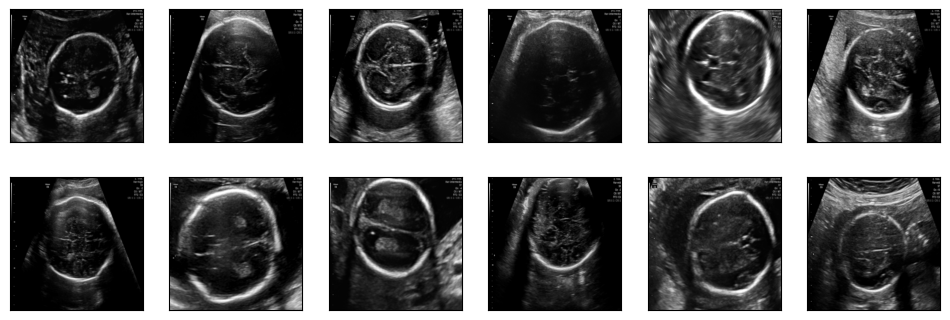

<Figure size 640x480 with 0 Axes>

In [2]:
# ['Trans-thalamic', 'Trans-cerebellum', 'Trans-ventricular']
brain_plane = 'Trans-thalamic'
training_data = getDataset(brain_plane, size=256, show_img=True)


In [3]:
test_data = torch.load(f'data/images/test/{brain_plane}.pt', map_location=torch.device('cpu'))
test_len = len(test_data)
test_len


215


## 2. Define loss


In [4]:
def discriminator_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)
    return real_loss.mean() + fake_loss.mean()


def generator_loss(fake_pred):
    return F.softplus(-fake_pred).mean()



## 3. Training loop setup



### 3.1 Initialize parameters for DiffAug and APA


In [5]:
# DiffAug policy
policy = "flip,color,translation"

# APA parameters
APA_p = 0.0
APA_threshold = 0.95
APA_speed = 1e-6
APA_update_step = 4
APA_start_epoch = 20
APA_max_prob = 0.6
lambda_r = 0.0



### 3.2 Setup training loop for one epoch


In [6]:
def generator_step(batch_size, latent_dim, policy=policy):
    """ One training step of the generator. """
    g_optimizer.zero_grad()
    generator.train()
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        latent = torch.randn(batch_size, latent_dim).float().requires_grad_(False).to(device)
        fake_images = DiffAugment(generator(latent), policy=policy)
        d_fake = discriminator(fake_images)
        g_loss = generator_loss(d_fake)
    scaler.scale(g_loss).backward()
    scaler.step(g_optimizer)
    
    del fake_images
    
    return {'loss': g_loss}


def discriminator_step(batch_size, latent_dim, real_images, APA_p, policy=policy):
    """ One training step of the discriminator. """
    d_optimizer.zero_grad()
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        latent = torch.randn(batch_size, latent_dim).float().requires_grad_(False).to(device)
        real_images = DiffAugment(real_images, policy=policy)
        with torch.no_grad():
            generator.eval()
            fake_images = DiffAugment(generator(latent), policy=policy)

            # implement APA
            num_mix_fakes = (torch.rand(batch_size) < APA_p).sum().item()
            if num_mix_fakes > 0:
                mix_latent = torch.randn(num_mix_fakes, latent_dim).float().requires_grad_(False).to(device)
                mix_fake_images = generator(mix_latent)
                real_images = torch.cat([real_images[:(batch_size - num_mix_fakes)], mix_fake_images])

        d_real = discriminator(real_images)
        d_fake = discriminator(fake_images.detach())
        d_loss = discriminator_loss(d_real, d_fake)
        
    scaler.scale(d_loss).backward()
    scaler.step(d_optimizer)
    
    # update lambda_r for APA
    if (epoch + 1) % APA_update_step == 0 and epoch >= APA_start_epoch:
        lambda_rs = []

        for d_r in d_real[:(batch_size - num_mix_fakes)]:
            _lambda_r = d_r.sign().mean().item()
            lambda_rs.append(_lambda_r)

        if len(lambda_rs) != 0:
            lambda_r = sum(lambda_rs) / len(lambda_rs)
            APA_p += np.sign(lambda_r - APA_threshold) * APA_speed * batch_size * APA_update_step
            APA_p = np.clip(APA_p, 0., APA_max_prob)
            
    scaler.update()
    
    return {'loss': d_loss}, APA_p



## 4. Hyperparameters, initialization, and helper functions


In [7]:
latent_dim = 512
n_epochs = 500
batch_size = 24
d_lr = 0.0002
g_lr = 0.00005
beta1 = 0.0
beta2 = 0.99


In [8]:
train_dataloader = DataLoader(training_data, batch_size, num_workers=4, shuffle=True, drop_last=True)
discriminator = Discriminator().to(device)
generator = Generator().to(device)
d_optimizer = torch.optim.Adam(discriminator.parameters(), d_lr, [beta1, beta2])
g_optimizer = torch.optim.Adam(generator.parameters(), g_lr, [beta1, beta2])
fid = FrechetInceptionDistance(feature=64).to('cpu')
scaler = torch.cuda.amp.GradScaler()


In [10]:
def display(generated_images):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(6, 4))
    plot_size = 3
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(1, int(plot_size), idx+1, xticks=[], yticks=[])
        img = denormalize(generated_images[idx]).squeeze().detach().cpu().numpy()
        ax.imshow(img, cmap='gray')
    plt.show()
    plt.clf()


def expand_channel(x):
    # repeats channel for 3 times
    return x.repeat(1, 3, 1, 1)



## 5. Train the model


Epoch [  1/500] | D loss:  1.29 | G loss:  0.52 | P(apa): 0.00
Epoch [  2/500] | D loss:  1.16 | G loss:  0.74 | P(apa): 0.00
Epoch [  3/500] | D loss:  1.30 | G loss:  0.82 | P(apa): 0.00
Epoch [  4/500] | D loss:  1.35 | G loss:  0.96 | P(apa): 0.00
Epoch [  5/500] | D loss:  1.40 | G loss:  0.73 | P(apa): 0.00
Epoch [  6/500] | D loss:  1.37 | G loss:  0.59 | P(apa): 0.00
Epoch [  7/500] | D loss:  1.37 | G loss:  0.60 | P(apa): 0.00
Epoch [  8/500] | D loss:  1.40 | G loss:  0.60 | P(apa): 0.00
Epoch [  9/500] | D loss:  1.36 | G loss:  0.61 | P(apa): 0.00
Epoch [ 10/500] | D loss:  1.36 | G loss:  0.94 | P(apa): 0.00
Check point saved; FID: 19.93


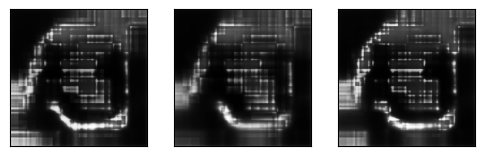

Epoch [ 11/500] | D loss:  1.45 | G loss:  0.64 | P(apa): 0.00
Epoch [ 12/500] | D loss:  1.32 | G loss:  0.66 | P(apa): 0.00
Epoch [ 13/500] | D loss:  1.40 | G loss:  0.55 | P(apa): 0.00
Epoch [ 14/500] | D loss:  1.38 | G loss:  0.66 | P(apa): 0.00
Epoch [ 15/500] | D loss:  1.59 | G loss:  0.42 | P(apa): 0.00
Epoch [ 16/500] | D loss:  1.36 | G loss:  0.78 | P(apa): 0.00
Epoch [ 17/500] | D loss:  1.36 | G loss:  0.88 | P(apa): 0.00
Epoch [ 18/500] | D loss:  1.41 | G loss:  0.67 | P(apa): 0.00
Epoch [ 19/500] | D loss:  1.45 | G loss:  0.53 | P(apa): 0.00
Epoch [ 20/500] | D loss:  1.36 | G loss:  0.70 | P(apa): 0.00
Check point saved; FID: 22.06


<Figure size 640x480 with 0 Axes>

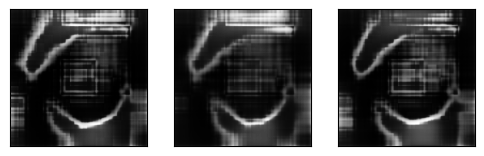

Epoch [ 21/500] | D loss:  1.37 | G loss:  0.80 | P(apa): 0.00
Epoch [ 22/500] | D loss:  1.45 | G loss:  0.65 | P(apa): 0.00
Epoch [ 23/500] | D loss:  1.39 | G loss:  0.66 | P(apa): 0.00
Epoch [ 24/500] | D loss:  1.46 | G loss:  0.86 | P(apa): 0.00
Epoch [ 25/500] | D loss:  1.34 | G loss:  0.67 | P(apa): 0.00
Epoch [ 26/500] | D loss:  1.52 | G loss:  1.02 | P(apa): 0.00
Epoch [ 27/500] | D loss:  1.39 | G loss:  0.81 | P(apa): 0.00
Epoch [ 28/500] | D loss:  1.35 | G loss:  0.75 | P(apa): 0.00
Epoch [ 29/500] | D loss:  1.36 | G loss:  0.79 | P(apa): 0.00
Epoch [ 30/500] | D loss:  1.36 | G loss:  0.56 | P(apa): 0.00
Check point saved; FID: 23.24


<Figure size 640x480 with 0 Axes>

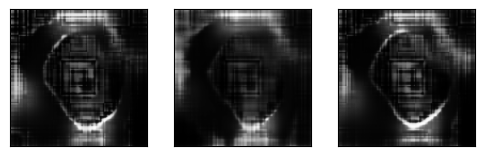

Epoch [ 31/500] | D loss:  1.37 | G loss:  0.86 | P(apa): 0.00
Epoch [ 32/500] | D loss:  1.37 | G loss:  0.72 | P(apa): 0.00
Epoch [ 33/500] | D loss:  1.35 | G loss:  0.61 | P(apa): 0.00
Epoch [ 34/500] | D loss:  1.37 | G loss:  0.70 | P(apa): 0.00
Epoch [ 35/500] | D loss:  1.33 | G loss:  0.76 | P(apa): 0.00
Epoch [ 36/500] | D loss:  1.35 | G loss:  0.89 | P(apa): 0.00
Epoch [ 37/500] | D loss:  1.35 | G loss:  0.70 | P(apa): 0.00
Epoch [ 38/500] | D loss:  1.42 | G loss:  0.90 | P(apa): 0.00
Epoch [ 39/500] | D loss:  1.34 | G loss:  0.86 | P(apa): 0.00
Epoch [ 40/500] | D loss:  1.36 | G loss:  0.68 | P(apa): 0.00
Check point saved; FID: 25.06


<Figure size 640x480 with 0 Axes>

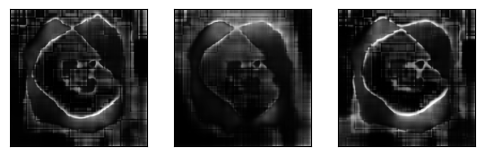

Epoch [ 41/500] | D loss:  1.30 | G loss:  0.78 | P(apa): 0.00
Epoch [ 42/500] | D loss:  1.36 | G loss:  0.88 | P(apa): 0.00
Epoch [ 43/500] | D loss:  1.37 | G loss:  0.85 | P(apa): 0.00
Epoch [ 44/500] | D loss:  1.31 | G loss:  0.85 | P(apa): 0.00
Epoch [ 45/500] | D loss:  1.40 | G loss:  1.02 | P(apa): 0.00
Epoch [ 46/500] | D loss:  1.44 | G loss:  1.12 | P(apa): 0.00
Epoch [ 47/500] | D loss:  1.30 | G loss:  0.52 | P(apa): 0.00
Epoch [ 48/500] | D loss:  1.32 | G loss:  0.69 | P(apa): 0.00
Epoch [ 49/500] | D loss:  1.38 | G loss:  0.79 | P(apa): 0.00
Epoch [ 50/500] | D loss:  1.31 | G loss:  0.82 | P(apa): 0.00
Check point saved; FID: 28.74


<Figure size 640x480 with 0 Axes>

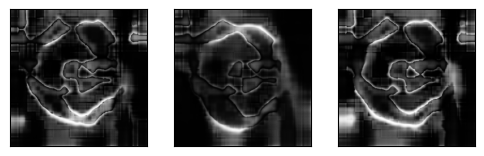

Epoch [ 51/500] | D loss:  1.36 | G loss:  0.70 | P(apa): 0.00
Epoch [ 52/500] | D loss:  1.40 | G loss:  0.74 | P(apa): 0.00
Epoch [ 53/500] | D loss:  1.39 | G loss:  0.77 | P(apa): 0.00
Epoch [ 54/500] | D loss:  1.37 | G loss:  0.69 | P(apa): 0.00
Epoch [ 55/500] | D loss:  1.40 | G loss:  0.90 | P(apa): 0.00
Epoch [ 56/500] | D loss:  1.34 | G loss:  0.60 | P(apa): 0.00
Epoch [ 57/500] | D loss:  1.39 | G loss:  0.65 | P(apa): 0.00
Epoch [ 58/500] | D loss:  1.37 | G loss:  0.64 | P(apa): 0.00
Epoch [ 59/500] | D loss:  1.36 | G loss:  0.98 | P(apa): 0.00
Epoch [ 60/500] | D loss:  1.39 | G loss:  0.75 | P(apa): 0.00
Check point saved; FID: 28.69


<Figure size 640x480 with 0 Axes>

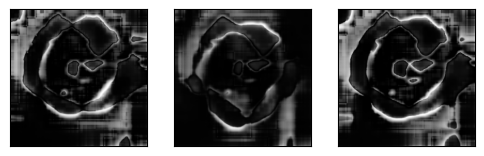

Epoch [ 61/500] | D loss:  1.39 | G loss:  0.77 | P(apa): 0.00
Epoch [ 62/500] | D loss:  1.35 | G loss:  0.66 | P(apa): 0.00
Epoch [ 63/500] | D loss:  1.38 | G loss:  0.59 | P(apa): 0.00
Epoch [ 64/500] | D loss:  1.35 | G loss:  0.85 | P(apa): 0.00
Epoch [ 65/500] | D loss:  1.35 | G loss:  0.76 | P(apa): 0.00
Epoch [ 66/500] | D loss:  1.39 | G loss:  0.73 | P(apa): 0.00
Epoch [ 67/500] | D loss:  1.45 | G loss:  0.63 | P(apa): 0.00
Epoch [ 68/500] | D loss:  1.39 | G loss:  0.94 | P(apa): 0.00
Epoch [ 69/500] | D loss:  1.35 | G loss:  0.80 | P(apa): 0.00
Epoch [ 70/500] | D loss:  1.41 | G loss:  0.50 | P(apa): 0.00
Check point saved; FID: 27.95


<Figure size 640x480 with 0 Axes>

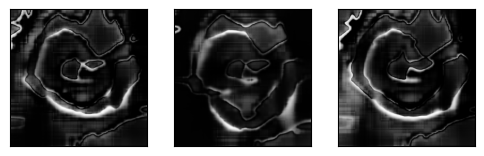

Epoch [ 71/500] | D loss:  1.35 | G loss:  0.69 | P(apa): 0.00
Epoch [ 72/500] | D loss:  1.39 | G loss:  0.65 | P(apa): 0.00
Epoch [ 73/500] | D loss:  1.37 | G loss:  0.75 | P(apa): 0.00
Epoch [ 74/500] | D loss:  1.39 | G loss:  0.85 | P(apa): 0.00
Epoch [ 75/500] | D loss:  1.36 | G loss:  0.64 | P(apa): 0.00
Epoch [ 76/500] | D loss:  1.35 | G loss:  0.69 | P(apa): 0.00
Epoch [ 77/500] | D loss:  1.44 | G loss:  0.57 | P(apa): 0.00
Epoch [ 78/500] | D loss:  1.37 | G loss:  0.74 | P(apa): 0.00
Epoch [ 79/500] | D loss:  1.37 | G loss:  0.79 | P(apa): 0.00
Epoch [ 80/500] | D loss:  1.34 | G loss:  0.70 | P(apa): 0.00
Check point saved; FID: 23.23


<Figure size 640x480 with 0 Axes>

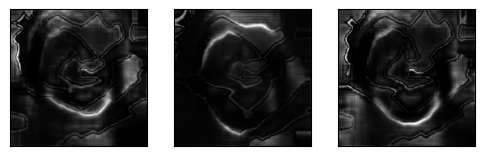

Epoch [ 81/500] | D loss:  1.36 | G loss:  0.67 | P(apa): 0.00
Epoch [ 82/500] | D loss:  1.36 | G loss:  0.67 | P(apa): 0.00
Epoch [ 83/500] | D loss:  1.34 | G loss:  0.66 | P(apa): 0.00
Epoch [ 84/500] | D loss:  1.31 | G loss:  0.82 | P(apa): 0.00
Epoch [ 85/500] | D loss:  1.38 | G loss:  0.78 | P(apa): 0.00
Epoch [ 86/500] | D loss:  1.30 | G loss:  0.76 | P(apa): 0.00
Epoch [ 87/500] | D loss:  1.42 | G loss:  0.82 | P(apa): 0.00
Epoch [ 88/500] | D loss:  1.26 | G loss:  0.73 | P(apa): 0.00
Epoch [ 89/500] | D loss:  1.27 | G loss:  0.62 | P(apa): 0.00
Epoch [ 90/500] | D loss:  1.29 | G loss:  0.85 | P(apa): 0.00
Check point saved; FID: 25.92


<Figure size 640x480 with 0 Axes>

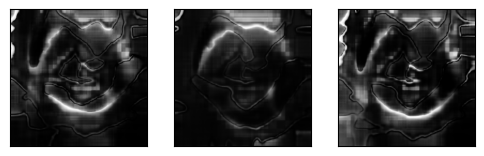

Epoch [ 91/500] | D loss:  1.34 | G loss:  0.73 | P(apa): 0.00
Epoch [ 92/500] | D loss:  1.34 | G loss:  0.88 | P(apa): 0.00
Epoch [ 93/500] | D loss:  1.39 | G loss:  0.51 | P(apa): 0.00
Epoch [ 94/500] | D loss:  1.28 | G loss:  0.71 | P(apa): 0.00
Epoch [ 95/500] | D loss:  1.24 | G loss:  0.96 | P(apa): 0.00
Epoch [ 96/500] | D loss:  1.23 | G loss:  0.90 | P(apa): 0.00
Epoch [ 97/500] | D loss:  1.35 | G loss:  0.81 | P(apa): 0.00
Epoch [ 98/500] | D loss:  1.26 | G loss:  0.70 | P(apa): 0.00
Epoch [ 99/500] | D loss:  1.31 | G loss:  0.69 | P(apa): 0.00
Epoch [100/500] | D loss:  1.40 | G loss:  0.64 | P(apa): 0.00
Check point saved; FID: 28.00


<Figure size 640x480 with 0 Axes>

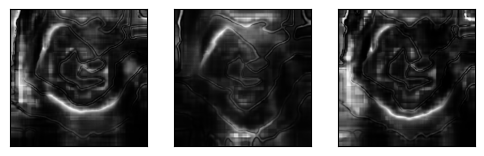

Epoch [101/500] | D loss:  1.33 | G loss:  0.70 | P(apa): 0.00
Epoch [102/500] | D loss:  1.34 | G loss:  0.80 | P(apa): 0.00
Epoch [103/500] | D loss:  1.38 | G loss:  0.81 | P(apa): 0.00
Epoch [104/500] | D loss:  1.37 | G loss:  0.75 | P(apa): 0.00
Epoch [105/500] | D loss:  1.40 | G loss:  0.60 | P(apa): 0.00
Epoch [106/500] | D loss:  1.29 | G loss:  0.87 | P(apa): 0.00
Epoch [107/500] | D loss:  1.37 | G loss:  0.98 | P(apa): 0.00
Epoch [108/500] | D loss:  1.45 | G loss:  0.69 | P(apa): 0.00
Epoch [109/500] | D loss:  1.30 | G loss:  0.76 | P(apa): 0.00
Epoch [110/500] | D loss:  1.32 | G loss:  0.69 | P(apa): 0.00
Check point saved; FID: 24.54


<Figure size 640x480 with 0 Axes>

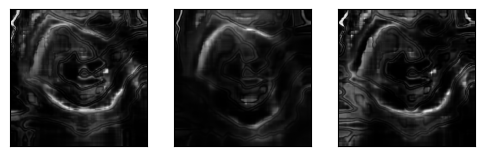

Epoch [111/500] | D loss:  1.33 | G loss:  0.75 | P(apa): 0.00
Epoch [112/500] | D loss:  1.42 | G loss:  0.87 | P(apa): 0.00
Epoch [113/500] | D loss:  1.39 | G loss:  1.02 | P(apa): 0.00
Epoch [114/500] | D loss:  1.37 | G loss:  0.88 | P(apa): 0.00
Epoch [115/500] | D loss:  1.51 | G loss:  0.76 | P(apa): 0.00
Epoch [116/500] | D loss:  1.38 | G loss:  0.71 | P(apa): 0.00
Epoch [117/500] | D loss:  1.33 | G loss:  0.85 | P(apa): 0.00
Epoch [118/500] | D loss:  1.34 | G loss:  0.75 | P(apa): 0.00
Epoch [119/500] | D loss:  1.35 | G loss:  0.62 | P(apa): 0.00
Epoch [120/500] | D loss:  1.36 | G loss:  0.72 | P(apa): 0.00
Check point saved; FID: 28.12


<Figure size 640x480 with 0 Axes>

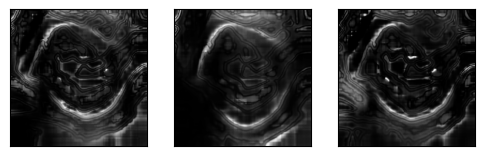

Epoch [121/500] | D loss:  1.35 | G loss:  0.69 | P(apa): 0.00
Epoch [122/500] | D loss:  1.30 | G loss:  0.64 | P(apa): 0.00
Epoch [123/500] | D loss:  1.37 | G loss:  0.77 | P(apa): 0.00
Epoch [124/500] | D loss:  1.32 | G loss:  0.67 | P(apa): 0.00
Epoch [125/500] | D loss:  1.34 | G loss:  0.64 | P(apa): 0.00
Epoch [126/500] | D loss:  1.44 | G loss:  0.88 | P(apa): 0.00
Epoch [127/500] | D loss:  1.37 | G loss:  0.74 | P(apa): 0.00
Epoch [128/500] | D loss:  1.37 | G loss:  0.75 | P(apa): 0.00
Epoch [129/500] | D loss:  1.32 | G loss:  0.80 | P(apa): 0.00
Epoch [130/500] | D loss:  1.36 | G loss:  0.72 | P(apa): 0.00
Check point saved; FID: 27.51


<Figure size 640x480 with 0 Axes>

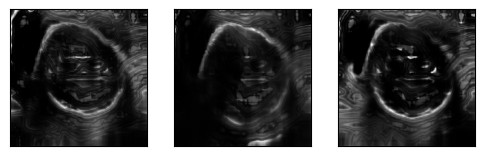

Epoch [131/500] | D loss:  1.49 | G loss:  0.88 | P(apa): 0.00
Epoch [132/500] | D loss:  1.43 | G loss:  0.91 | P(apa): 0.00
Epoch [133/500] | D loss:  1.46 | G loss:  0.84 | P(apa): 0.00
Epoch [134/500] | D loss:  1.36 | G loss:  0.64 | P(apa): 0.00
Epoch [135/500] | D loss:  1.46 | G loss:  1.13 | P(apa): 0.00
Epoch [136/500] | D loss:  1.33 | G loss:  0.90 | P(apa): 0.00
Epoch [137/500] | D loss:  1.32 | G loss:  0.91 | P(apa): 0.00
Epoch [138/500] | D loss:  1.40 | G loss:  0.69 | P(apa): 0.00
Epoch [139/500] | D loss:  1.31 | G loss:  0.74 | P(apa): 0.00
Epoch [140/500] | D loss:  1.34 | G loss:  0.65 | P(apa): 0.00
Check point saved; FID: 27.55


<Figure size 640x480 with 0 Axes>

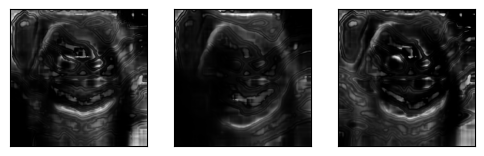

Epoch [141/500] | D loss:  1.37 | G loss:  0.77 | P(apa): 0.00
Epoch [142/500] | D loss:  1.37 | G loss:  0.69 | P(apa): 0.00
Epoch [143/500] | D loss:  1.37 | G loss:  0.72 | P(apa): 0.00
Epoch [144/500] | D loss:  1.41 | G loss:  0.81 | P(apa): 0.00
Epoch [145/500] | D loss:  1.36 | G loss:  0.81 | P(apa): 0.00
Epoch [146/500] | D loss:  1.37 | G loss:  0.75 | P(apa): 0.00
Epoch [147/500] | D loss:  1.37 | G loss:  0.81 | P(apa): 0.00
Epoch [148/500] | D loss:  1.38 | G loss:  0.76 | P(apa): 0.00
Epoch [149/500] | D loss:  1.34 | G loss:  0.72 | P(apa): 0.00
Epoch [150/500] | D loss:  1.35 | G loss:  0.67 | P(apa): 0.00
Check point saved; FID: 26.36


<Figure size 640x480 with 0 Axes>

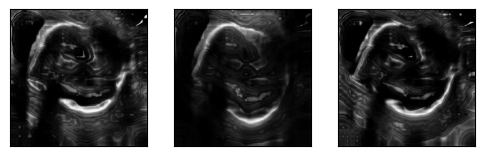

Epoch [151/500] | D loss:  1.37 | G loss:  0.71 | P(apa): 0.00
Epoch [152/500] | D loss:  1.36 | G loss:  0.76 | P(apa): 0.00
Epoch [153/500] | D loss:  1.38 | G loss:  0.92 | P(apa): 0.00
Epoch [154/500] | D loss:  1.37 | G loss:  0.67 | P(apa): 0.00
Epoch [155/500] | D loss:  1.47 | G loss:  0.71 | P(apa): 0.00
Epoch [156/500] | D loss:  1.40 | G loss:  0.69 | P(apa): 0.00
Epoch [157/500] | D loss:  1.40 | G loss:  0.78 | P(apa): 0.00
Epoch [158/500] | D loss:  1.30 | G loss:  0.77 | P(apa): 0.00
Epoch [159/500] | D loss:  1.39 | G loss:  0.87 | P(apa): 0.00
Epoch [160/500] | D loss:  1.34 | G loss:  0.89 | P(apa): 0.00
Check point saved; FID: 29.80


<Figure size 640x480 with 0 Axes>

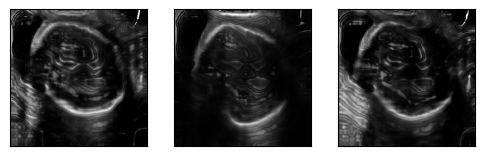

Epoch [161/500] | D loss:  1.41 | G loss:  0.71 | P(apa): 0.00
Epoch [162/500] | D loss:  1.32 | G loss:  0.80 | P(apa): 0.00
Epoch [163/500] | D loss:  1.38 | G loss:  0.82 | P(apa): 0.00
Epoch [164/500] | D loss:  1.36 | G loss:  0.78 | P(apa): 0.00
Epoch [165/500] | D loss:  1.37 | G loss:  0.89 | P(apa): 0.00
Epoch [166/500] | D loss:  1.35 | G loss:  0.73 | P(apa): 0.00
Epoch [167/500] | D loss:  1.33 | G loss:  0.85 | P(apa): 0.00
Epoch [168/500] | D loss:  1.29 | G loss:  0.76 | P(apa): 0.00
Epoch [169/500] | D loss:  1.33 | G loss:  0.72 | P(apa): 0.00
Epoch [170/500] | D loss:  1.36 | G loss:  0.78 | P(apa): 0.00
Check point saved; FID: 31.40


<Figure size 640x480 with 0 Axes>

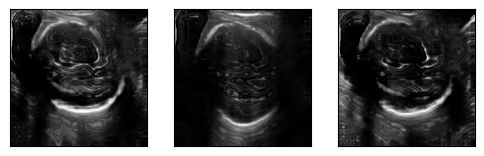

Epoch [171/500] | D loss:  1.38 | G loss:  0.66 | P(apa): 0.00
Epoch [172/500] | D loss:  1.38 | G loss:  0.99 | P(apa): 0.00
Epoch [173/500] | D loss:  1.35 | G loss:  0.72 | P(apa): 0.00
Epoch [174/500] | D loss:  1.34 | G loss:  0.77 | P(apa): 0.00
Epoch [175/500] | D loss:  1.40 | G loss:  0.75 | P(apa): 0.00
Epoch [176/500] | D loss:  1.34 | G loss:  0.71 | P(apa): 0.00
Epoch [177/500] | D loss:  1.32 | G loss:  0.79 | P(apa): 0.00
Epoch [178/500] | D loss:  1.35 | G loss:  0.77 | P(apa): 0.00
Epoch [179/500] | D loss:  1.37 | G loss:  0.82 | P(apa): 0.00
Epoch [180/500] | D loss:  1.34 | G loss:  0.77 | P(apa): 0.00
Check point saved; FID: 27.85


<Figure size 640x480 with 0 Axes>

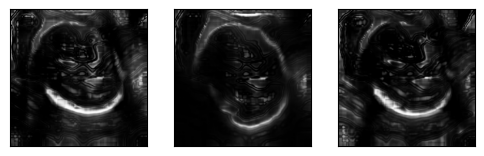

Epoch [181/500] | D loss:  1.43 | G loss:  0.77 | P(apa): 0.00
Epoch [182/500] | D loss:  1.32 | G loss:  0.71 | P(apa): 0.00
Epoch [183/500] | D loss:  1.30 | G loss:  0.68 | P(apa): 0.00
Epoch [184/500] | D loss:  1.30 | G loss:  0.68 | P(apa): 0.00
Epoch [185/500] | D loss:  1.31 | G loss:  0.79 | P(apa): 0.00
Epoch [186/500] | D loss:  1.34 | G loss:  0.67 | P(apa): 0.00
Epoch [187/500] | D loss:  1.40 | G loss:  0.81 | P(apa): 0.00
Epoch [188/500] | D loss:  1.40 | G loss:  0.65 | P(apa): 0.00
Epoch [189/500] | D loss:  1.30 | G loss:  0.68 | P(apa): 0.00
Epoch [190/500] | D loss:  1.35 | G loss:  0.76 | P(apa): 0.00
Check point saved; FID: 35.60


<Figure size 640x480 with 0 Axes>

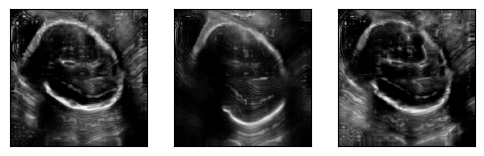

Epoch [191/500] | D loss:  1.32 | G loss:  0.84 | P(apa): 0.00
Epoch [192/500] | D loss:  1.47 | G loss:  0.74 | P(apa): 0.00
Epoch [193/500] | D loss:  1.39 | G loss:  0.84 | P(apa): 0.00
Epoch [194/500] | D loss:  1.35 | G loss:  0.66 | P(apa): 0.00
Epoch [195/500] | D loss:  1.38 | G loss:  0.70 | P(apa): 0.00
Epoch [196/500] | D loss:  1.33 | G loss:  0.73 | P(apa): 0.00
Epoch [197/500] | D loss:  1.38 | G loss:  0.75 | P(apa): 0.00
Epoch [198/500] | D loss:  1.32 | G loss:  0.89 | P(apa): 0.00
Epoch [199/500] | D loss:  1.41 | G loss:  0.70 | P(apa): 0.00
Epoch [200/500] | D loss:  1.32 | G loss:  0.75 | P(apa): 0.00
Check point saved; FID: 38.16


<Figure size 640x480 with 0 Axes>

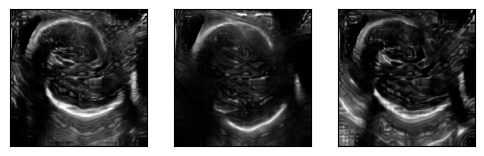

Epoch [201/500] | D loss:  1.36 | G loss:  0.77 | P(apa): 0.00
Epoch [202/500] | D loss:  1.36 | G loss:  0.73 | P(apa): 0.00
Epoch [203/500] | D loss:  1.31 | G loss:  0.78 | P(apa): 0.00
Epoch [204/500] | D loss:  1.34 | G loss:  0.70 | P(apa): 0.00
Epoch [205/500] | D loss:  1.31 | G loss:  1.07 | P(apa): 0.00
Epoch [206/500] | D loss:  1.38 | G loss:  0.82 | P(apa): 0.00
Epoch [207/500] | D loss:  1.39 | G loss:  0.74 | P(apa): 0.00
Epoch [208/500] | D loss:  1.35 | G loss:  0.76 | P(apa): 0.00
Epoch [209/500] | D loss:  1.34 | G loss:  0.84 | P(apa): 0.00
Epoch [210/500] | D loss:  1.35 | G loss:  0.78 | P(apa): 0.00
Check point saved; FID: 30.10


<Figure size 640x480 with 0 Axes>

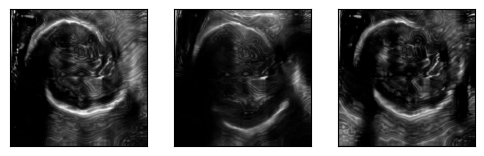

Epoch [211/500] | D loss:  1.36 | G loss:  0.79 | P(apa): 0.00
Epoch [212/500] | D loss:  1.33 | G loss:  0.79 | P(apa): 0.00
Epoch [213/500] | D loss:  1.34 | G loss:  0.74 | P(apa): 0.00
Epoch [214/500] | D loss:  1.36 | G loss:  0.75 | P(apa): 0.00
Epoch [215/500] | D loss:  1.27 | G loss:  0.81 | P(apa): 0.00
Epoch [216/500] | D loss:  1.35 | G loss:  0.76 | P(apa): 0.00
Epoch [217/500] | D loss:  1.37 | G loss:  0.95 | P(apa): 0.00
Epoch [218/500] | D loss:  1.30 | G loss:  0.67 | P(apa): 0.00
Epoch [219/500] | D loss:  1.40 | G loss:  0.75 | P(apa): 0.00
Epoch [220/500] | D loss:  1.35 | G loss:  0.71 | P(apa): 0.00
Check point saved; FID: 40.83


<Figure size 640x480 with 0 Axes>

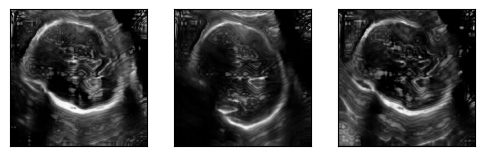

Epoch [221/500] | D loss:  1.34 | G loss:  0.71 | P(apa): 0.00
Epoch [222/500] | D loss:  1.36 | G loss:  0.81 | P(apa): 0.00
Epoch [223/500] | D loss:  1.40 | G loss:  0.89 | P(apa): 0.00
Epoch [224/500] | D loss:  1.36 | G loss:  0.85 | P(apa): 0.00
Epoch [225/500] | D loss:  1.38 | G loss:  0.64 | P(apa): 0.00
Epoch [226/500] | D loss:  1.41 | G loss:  0.64 | P(apa): 0.00
Epoch [227/500] | D loss:  1.32 | G loss:  0.74 | P(apa): 0.00
Epoch [228/500] | D loss:  1.36 | G loss:  0.62 | P(apa): 0.00
Epoch [229/500] | D loss:  1.29 | G loss:  0.85 | P(apa): 0.00
Epoch [230/500] | D loss:  1.40 | G loss:  0.78 | P(apa): 0.00
Check point saved; FID: 25.86


<Figure size 640x480 with 0 Axes>

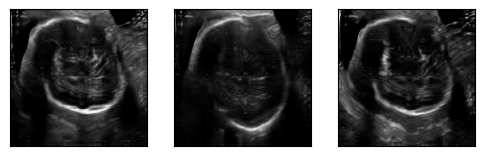

Epoch [231/500] | D loss:  1.35 | G loss:  0.69 | P(apa): 0.00
Epoch [232/500] | D loss:  1.37 | G loss:  0.74 | P(apa): 0.00
Epoch [233/500] | D loss:  1.40 | G loss:  0.86 | P(apa): 0.00
Epoch [234/500] | D loss:  1.37 | G loss:  0.84 | P(apa): 0.00
Epoch [235/500] | D loss:  1.37 | G loss:  0.62 | P(apa): 0.00
Epoch [236/500] | D loss:  1.37 | G loss:  0.90 | P(apa): 0.00
Epoch [237/500] | D loss:  1.31 | G loss:  0.88 | P(apa): 0.00
Epoch [238/500] | D loss:  1.44 | G loss:  0.68 | P(apa): 0.00
Epoch [239/500] | D loss:  1.36 | G loss:  0.72 | P(apa): 0.00
Epoch [240/500] | D loss:  1.35 | G loss:  0.66 | P(apa): 0.00
Check point saved; FID: 31.62


<Figure size 640x480 with 0 Axes>

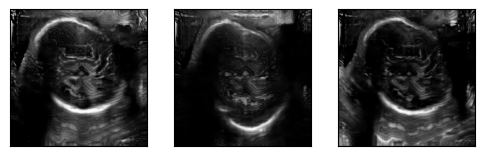

Epoch [241/500] | D loss:  1.35 | G loss:  0.70 | P(apa): 0.00
Epoch [242/500] | D loss:  1.27 | G loss:  0.66 | P(apa): 0.00
Epoch [243/500] | D loss:  1.32 | G loss:  0.92 | P(apa): 0.00
Epoch [244/500] | D loss:  1.45 | G loss:  0.69 | P(apa): 0.00
Epoch [245/500] | D loss:  1.34 | G loss:  0.81 | P(apa): 0.00
Epoch [246/500] | D loss:  1.28 | G loss:  0.71 | P(apa): 0.00
Epoch [247/500] | D loss:  1.38 | G loss:  0.84 | P(apa): 0.00
Epoch [248/500] | D loss:  1.44 | G loss:  1.03 | P(apa): 0.00
Epoch [249/500] | D loss:  1.27 | G loss:  0.66 | P(apa): 0.00
Epoch [250/500] | D loss:  1.37 | G loss:  0.88 | P(apa): 0.00
Check point saved; FID: 31.46


<Figure size 640x480 with 0 Axes>

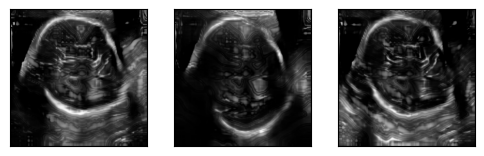

Epoch [251/500] | D loss:  1.35 | G loss:  0.91 | P(apa): 0.00
Epoch [252/500] | D loss:  1.35 | G loss:  0.80 | P(apa): 0.00
Epoch [253/500] | D loss:  1.44 | G loss:  0.76 | P(apa): 0.00
Epoch [254/500] | D loss:  1.35 | G loss:  0.75 | P(apa): 0.00
Epoch [255/500] | D loss:  1.32 | G loss:  0.89 | P(apa): 0.00
Epoch [256/500] | D loss:  1.37 | G loss:  0.66 | P(apa): 0.00
Epoch [257/500] | D loss:  1.34 | G loss:  0.80 | P(apa): 0.00
Epoch [258/500] | D loss:  1.40 | G loss:  0.67 | P(apa): 0.00
Epoch [259/500] | D loss:  1.37 | G loss:  0.84 | P(apa): 0.00
Epoch [260/500] | D loss:  1.30 | G loss:  0.81 | P(apa): 0.00
Check point saved; FID: 31.88


<Figure size 640x480 with 0 Axes>

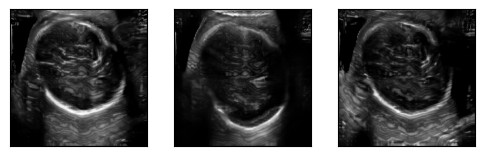

Epoch [261/500] | D loss:  1.33 | G loss:  0.75 | P(apa): 0.00
Epoch [262/500] | D loss:  1.48 | G loss:  0.69 | P(apa): 0.00
Epoch [263/500] | D loss:  1.38 | G loss:  0.78 | P(apa): 0.00
Epoch [264/500] | D loss:  1.30 | G loss:  0.80 | P(apa): 0.00
Epoch [265/500] | D loss:  1.36 | G loss:  0.64 | P(apa): 0.00
Epoch [266/500] | D loss:  1.34 | G loss:  0.85 | P(apa): 0.00
Epoch [267/500] | D loss:  1.28 | G loss:  0.73 | P(apa): 0.00
Epoch [268/500] | D loss:  1.47 | G loss:  1.00 | P(apa): 0.00
Epoch [269/500] | D loss:  1.38 | G loss:  0.70 | P(apa): 0.00
Epoch [270/500] | D loss:  1.36 | G loss:  0.81 | P(apa): 0.00
Check point saved; FID: 28.70


<Figure size 640x480 with 0 Axes>

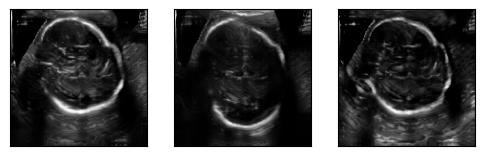

Epoch [271/500] | D loss:  1.37 | G loss:  0.67 | P(apa): 0.00
Epoch [272/500] | D loss:  1.35 | G loss:  0.90 | P(apa): 0.00
Epoch [273/500] | D loss:  1.45 | G loss:  0.87 | P(apa): 0.00
Epoch [274/500] | D loss:  1.35 | G loss:  0.75 | P(apa): 0.00
Epoch [275/500] | D loss:  1.35 | G loss:  0.68 | P(apa): 0.00
Epoch [276/500] | D loss:  1.37 | G loss:  0.82 | P(apa): 0.00
Epoch [277/500] | D loss:  1.38 | G loss:  0.78 | P(apa): 0.00
Epoch [278/500] | D loss:  1.44 | G loss:  0.68 | P(apa): 0.00
Epoch [279/500] | D loss:  1.33 | G loss:  0.92 | P(apa): 0.00
Epoch [280/500] | D loss:  1.33 | G loss:  0.93 | P(apa): 0.00
Check point saved; FID: 31.92


<Figure size 640x480 with 0 Axes>

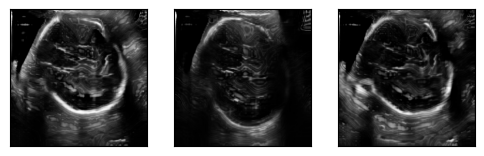

Epoch [281/500] | D loss:  1.34 | G loss:  0.76 | P(apa): 0.00
Epoch [282/500] | D loss:  1.34 | G loss:  0.70 | P(apa): 0.00
Epoch [283/500] | D loss:  1.32 | G loss:  0.67 | P(apa): 0.00
Epoch [284/500] | D loss:  1.35 | G loss:  0.73 | P(apa): 0.00
Epoch [285/500] | D loss:  1.34 | G loss:  0.83 | P(apa): 0.00
Epoch [286/500] | D loss:  1.39 | G loss:  0.65 | P(apa): 0.00
Epoch [287/500] | D loss:  1.35 | G loss:  0.78 | P(apa): 0.00
Epoch [288/500] | D loss:  1.33 | G loss:  0.68 | P(apa): 0.00
Epoch [289/500] | D loss:  1.42 | G loss:  0.90 | P(apa): 0.00
Epoch [290/500] | D loss:  1.37 | G loss:  0.69 | P(apa): 0.00
Check point saved; FID: 35.41


<Figure size 640x480 with 0 Axes>

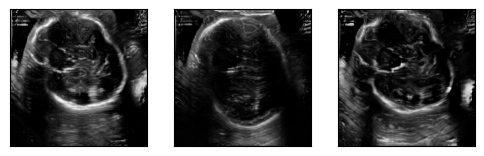

Epoch [291/500] | D loss:  1.33 | G loss:  0.82 | P(apa): 0.00
Epoch [292/500] | D loss:  1.38 | G loss:  0.78 | P(apa): 0.00
Epoch [293/500] | D loss:  1.36 | G loss:  0.74 | P(apa): 0.00
Epoch [294/500] | D loss:  1.37 | G loss:  0.65 | P(apa): 0.00
Epoch [295/500] | D loss:  1.37 | G loss:  0.86 | P(apa): 0.00
Epoch [296/500] | D loss:  1.34 | G loss:  0.63 | P(apa): 0.00
Epoch [297/500] | D loss:  1.39 | G loss:  0.61 | P(apa): 0.00
Epoch [298/500] | D loss:  1.39 | G loss:  0.84 | P(apa): 0.00
Epoch [299/500] | D loss:  1.41 | G loss:  0.72 | P(apa): 0.00
Epoch [300/500] | D loss:  1.39 | G loss:  0.77 | P(apa): 0.00
Check point saved; FID: 36.90


<Figure size 640x480 with 0 Axes>

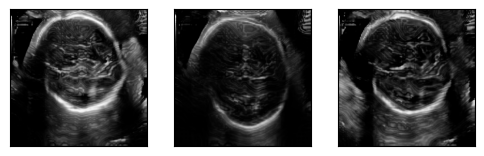

Epoch [301/500] | D loss:  1.39 | G loss:  0.90 | P(apa): 0.00
Epoch [302/500] | D loss:  1.42 | G loss:  0.98 | P(apa): 0.00
Epoch [303/500] | D loss:  1.41 | G loss:  0.66 | P(apa): 0.00
Epoch [304/500] | D loss:  1.35 | G loss:  0.75 | P(apa): 0.00
Epoch [305/500] | D loss:  1.39 | G loss:  0.64 | P(apa): 0.00
Epoch [306/500] | D loss:  1.41 | G loss:  0.74 | P(apa): 0.00
Epoch [307/500] | D loss:  1.29 | G loss:  1.11 | P(apa): 0.00
Epoch [308/500] | D loss:  1.31 | G loss:  0.72 | P(apa): 0.00
Epoch [309/500] | D loss:  1.36 | G loss:  0.61 | P(apa): 0.00
Epoch [310/500] | D loss:  1.32 | G loss:  0.80 | P(apa): 0.00
Check point saved; FID: 28.21


<Figure size 640x480 with 0 Axes>

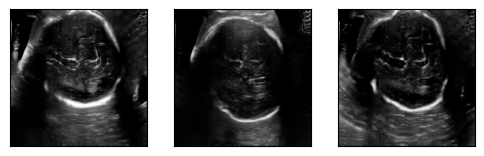

Epoch [311/500] | D loss:  1.54 | G loss:  0.89 | P(apa): 0.00
Epoch [312/500] | D loss:  1.37 | G loss:  0.85 | P(apa): 0.00
Epoch [313/500] | D loss:  1.37 | G loss:  0.93 | P(apa): 0.00
Epoch [314/500] | D loss:  1.48 | G loss:  0.80 | P(apa): 0.00
Epoch [315/500] | D loss:  1.38 | G loss:  0.78 | P(apa): 0.00
Epoch [316/500] | D loss:  1.37 | G loss:  0.67 | P(apa): 0.00
Epoch [317/500] | D loss:  1.42 | G loss:  0.64 | P(apa): 0.00
Epoch [318/500] | D loss:  1.31 | G loss:  0.68 | P(apa): 0.00
Epoch [319/500] | D loss:  1.34 | G loss:  0.77 | P(apa): 0.00
Epoch [320/500] | D loss:  1.40 | G loss:  0.79 | P(apa): 0.00
Check point saved; FID: 26.86


<Figure size 640x480 with 0 Axes>

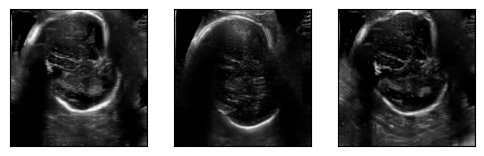

Epoch [321/500] | D loss:  1.38 | G loss:  0.73 | P(apa): 0.00
Epoch [322/500] | D loss:  1.47 | G loss:  0.89 | P(apa): 0.00
Epoch [323/500] | D loss:  1.38 | G loss:  0.72 | P(apa): 0.00
Epoch [324/500] | D loss:  1.32 | G loss:  0.74 | P(apa): 0.00
Epoch [325/500] | D loss:  1.34 | G loss:  0.74 | P(apa): 0.00
Epoch [326/500] | D loss:  1.36 | G loss:  0.90 | P(apa): 0.00
Epoch [327/500] | D loss:  1.40 | G loss:  0.86 | P(apa): 0.00
Epoch [328/500] | D loss:  1.37 | G loss:  0.84 | P(apa): 0.00
Epoch [329/500] | D loss:  1.52 | G loss:  0.54 | P(apa): 0.00
Epoch [330/500] | D loss:  1.32 | G loss:  0.75 | P(apa): 0.00
Check point saved; FID: 33.00


<Figure size 640x480 with 0 Axes>

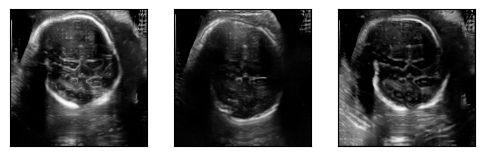

Epoch [331/500] | D loss:  1.37 | G loss:  0.76 | P(apa): 0.00
Epoch [332/500] | D loss:  1.35 | G loss:  0.73 | P(apa): 0.00
Epoch [333/500] | D loss:  1.28 | G loss:  0.83 | P(apa): 0.00
Epoch [334/500] | D loss:  1.43 | G loss:  0.73 | P(apa): 0.00
Epoch [335/500] | D loss:  1.39 | G loss:  0.65 | P(apa): 0.00
Epoch [336/500] | D loss:  1.38 | G loss:  0.73 | P(apa): 0.00
Epoch [337/500] | D loss:  1.38 | G loss:  0.86 | P(apa): 0.00
Epoch [338/500] | D loss:  1.46 | G loss:  0.64 | P(apa): 0.00
Epoch [339/500] | D loss:  1.46 | G loss:  0.62 | P(apa): 0.00
Epoch [340/500] | D loss:  1.31 | G loss:  0.77 | P(apa): 0.00
Check point saved; FID: 38.25


<Figure size 640x480 with 0 Axes>

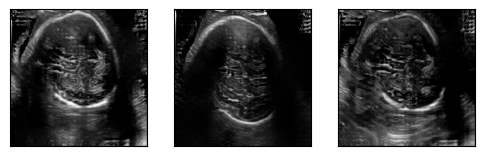

Epoch [341/500] | D loss:  1.27 | G loss:  0.84 | P(apa): 0.00
Epoch [342/500] | D loss:  1.30 | G loss:  0.89 | P(apa): 0.00
Epoch [343/500] | D loss:  1.36 | G loss:  0.87 | P(apa): 0.00
Epoch [344/500] | D loss:  1.42 | G loss:  0.67 | P(apa): 0.00
Epoch [345/500] | D loss:  1.30 | G loss:  0.69 | P(apa): 0.00
Epoch [346/500] | D loss:  1.37 | G loss:  0.78 | P(apa): 0.00
Epoch [347/500] | D loss:  1.41 | G loss:  0.67 | P(apa): 0.00
Epoch [348/500] | D loss:  1.30 | G loss:  0.72 | P(apa): 0.00
Epoch [349/500] | D loss:  1.35 | G loss:  0.73 | P(apa): 0.00
Epoch [350/500] | D loss:  1.38 | G loss:  0.84 | P(apa): 0.00
Check point saved; FID: 25.12


<Figure size 640x480 with 0 Axes>

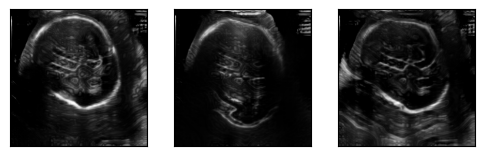

Epoch [351/500] | D loss:  1.31 | G loss:  0.80 | P(apa): 0.00
Epoch [352/500] | D loss:  1.31 | G loss:  0.86 | P(apa): 0.00
Epoch [353/500] | D loss:  1.31 | G loss:  0.75 | P(apa): 0.00
Epoch [354/500] | D loss:  1.32 | G loss:  0.84 | P(apa): 0.00
Epoch [355/500] | D loss:  1.35 | G loss:  0.78 | P(apa): 0.00
Epoch [356/500] | D loss:  1.38 | G loss:  0.75 | P(apa): 0.00
Epoch [357/500] | D loss:  1.37 | G loss:  0.82 | P(apa): 0.00
Epoch [358/500] | D loss:  1.43 | G loss:  0.62 | P(apa): 0.00
Epoch [359/500] | D loss:  1.32 | G loss:  0.57 | P(apa): 0.00
Epoch [360/500] | D loss:  1.37 | G loss:  0.66 | P(apa): 0.00
Check point saved; FID: 27.75


<Figure size 640x480 with 0 Axes>

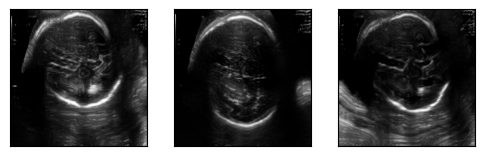

Epoch [361/500] | D loss:  1.35 | G loss:  0.73 | P(apa): 0.00
Epoch [362/500] | D loss:  1.32 | G loss:  0.79 | P(apa): 0.00
Epoch [363/500] | D loss:  1.31 | G loss:  0.86 | P(apa): 0.00
Epoch [364/500] | D loss:  1.37 | G loss:  0.64 | P(apa): 0.00
Epoch [365/500] | D loss:  1.39 | G loss:  0.68 | P(apa): 0.00
Epoch [366/500] | D loss:  1.35 | G loss:  0.71 | P(apa): 0.00
Epoch [367/500] | D loss:  1.33 | G loss:  0.76 | P(apa): 0.00
Epoch [368/500] | D loss:  1.26 | G loss:  0.80 | P(apa): 0.00
Epoch [369/500] | D loss:  1.45 | G loss:  0.74 | P(apa): 0.00
Epoch [370/500] | D loss:  1.35 | G loss:  0.71 | P(apa): 0.00
Check point saved; FID: 36.05


<Figure size 640x480 with 0 Axes>

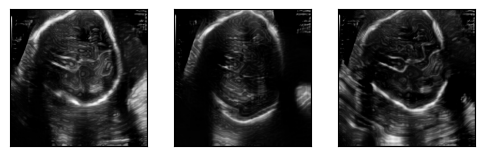

Epoch [371/500] | D loss:  1.41 | G loss:  0.65 | P(apa): 0.00
Epoch [372/500] | D loss:  1.38 | G loss:  0.70 | P(apa): 0.00
Epoch [373/500] | D loss:  1.29 | G loss:  0.81 | P(apa): 0.00
Epoch [374/500] | D loss:  1.34 | G loss:  0.74 | P(apa): 0.00
Epoch [375/500] | D loss:  1.39 | G loss:  0.84 | P(apa): 0.00
Epoch [376/500] | D loss:  1.37 | G loss:  0.67 | P(apa): 0.00
Epoch [377/500] | D loss:  1.38 | G loss:  0.83 | P(apa): 0.00
Epoch [378/500] | D loss:  1.35 | G loss:  0.77 | P(apa): 0.00
Epoch [379/500] | D loss:  1.42 | G loss:  0.70 | P(apa): 0.00
Epoch [380/500] | D loss:  1.36 | G loss:  0.83 | P(apa): 0.00
Check point saved; FID: 28.96


<Figure size 640x480 with 0 Axes>

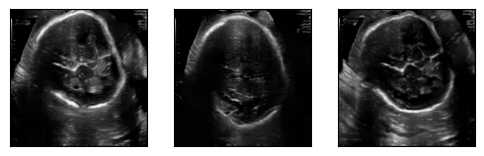

Epoch [381/500] | D loss:  1.41 | G loss:  0.75 | P(apa): 0.00
Epoch [382/500] | D loss:  1.39 | G loss:  0.78 | P(apa): 0.00
Epoch [383/500] | D loss:  1.40 | G loss:  0.59 | P(apa): 0.00
Epoch [384/500] | D loss:  1.41 | G loss:  0.86 | P(apa): 0.00
Epoch [385/500] | D loss:  1.36 | G loss:  0.79 | P(apa): 0.00
Epoch [386/500] | D loss:  1.34 | G loss:  0.74 | P(apa): 0.00
Epoch [387/500] | D loss:  1.37 | G loss:  0.67 | P(apa): 0.00
Epoch [388/500] | D loss:  1.36 | G loss:  0.79 | P(apa): 0.00
Epoch [389/500] | D loss:  1.40 | G loss:  0.76 | P(apa): 0.00
Epoch [390/500] | D loss:  1.31 | G loss:  0.79 | P(apa): 0.00
Check point saved; FID: 36.52


<Figure size 640x480 with 0 Axes>

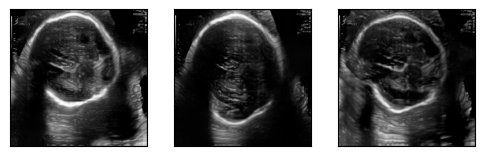

Epoch [391/500] | D loss:  1.43 | G loss:  0.80 | P(apa): 0.00
Epoch [392/500] | D loss:  1.44 | G loss:  0.62 | P(apa): 0.00
Epoch [393/500] | D loss:  1.31 | G loss:  0.67 | P(apa): 0.00
Epoch [394/500] | D loss:  1.28 | G loss:  0.80 | P(apa): 0.00
Epoch [395/500] | D loss:  1.35 | G loss:  0.72 | P(apa): 0.00
Epoch [396/500] | D loss:  1.33 | G loss:  0.76 | P(apa): 0.00
Epoch [397/500] | D loss:  1.33 | G loss:  0.73 | P(apa): 0.00
Epoch [398/500] | D loss:  1.38 | G loss:  0.68 | P(apa): 0.00
Epoch [399/500] | D loss:  1.32 | G loss:  0.83 | P(apa): 0.00
Epoch [400/500] | D loss:  1.41 | G loss:  0.83 | P(apa): 0.00
Check point saved; FID: 29.06


<Figure size 640x480 with 0 Axes>

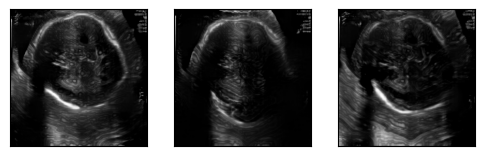

Epoch [401/500] | D loss:  1.36 | G loss:  0.85 | P(apa): 0.00
Epoch [402/500] | D loss:  1.39 | G loss:  0.79 | P(apa): 0.00
Epoch [403/500] | D loss:  1.43 | G loss:  0.75 | P(apa): 0.00
Epoch [404/500] | D loss:  1.29 | G loss:  0.68 | P(apa): 0.00
Epoch [405/500] | D loss:  1.34 | G loss:  0.78 | P(apa): 0.00
Epoch [406/500] | D loss:  1.38 | G loss:  0.91 | P(apa): 0.00
Epoch [407/500] | D loss:  1.47 | G loss:  0.85 | P(apa): 0.00
Epoch [408/500] | D loss:  1.43 | G loss:  0.71 | P(apa): 0.00
Epoch [409/500] | D loss:  1.41 | G loss:  0.91 | P(apa): 0.00
Epoch [410/500] | D loss:  1.37 | G loss:  0.81 | P(apa): 0.00
Check point saved; FID: 31.64


<Figure size 640x480 with 0 Axes>

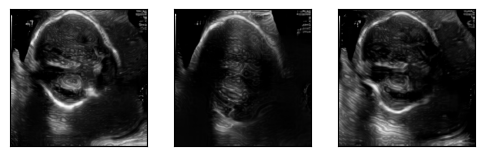

Epoch [411/500] | D loss:  1.37 | G loss:  0.77 | P(apa): 0.00
Epoch [412/500] | D loss:  1.39 | G loss:  0.68 | P(apa): 0.00
Epoch [413/500] | D loss:  1.39 | G loss:  0.72 | P(apa): 0.00
Epoch [414/500] | D loss:  1.42 | G loss:  0.70 | P(apa): 0.00
Epoch [415/500] | D loss:  1.35 | G loss:  0.68 | P(apa): 0.00
Epoch [416/500] | D loss:  1.38 | G loss:  0.77 | P(apa): 0.00
Epoch [417/500] | D loss:  1.40 | G loss:  0.79 | P(apa): 0.00
Epoch [418/500] | D loss:  1.36 | G loss:  0.72 | P(apa): 0.00
Epoch [419/500] | D loss:  1.41 | G loss:  0.77 | P(apa): 0.00
Epoch [420/500] | D loss:  1.31 | G loss:  0.70 | P(apa): 0.00
Check point saved; FID: 28.64


<Figure size 640x480 with 0 Axes>

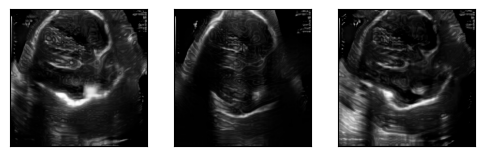

Epoch [421/500] | D loss:  1.31 | G loss:  0.78 | P(apa): 0.00
Epoch [422/500] | D loss:  1.38 | G loss:  0.79 | P(apa): 0.00
Epoch [423/500] | D loss:  1.42 | G loss:  0.81 | P(apa): 0.00
Epoch [424/500] | D loss:  1.37 | G loss:  0.65 | P(apa): 0.00
Epoch [425/500] | D loss:  1.34 | G loss:  0.75 | P(apa): 0.00
Epoch [426/500] | D loss:  1.37 | G loss:  0.79 | P(apa): 0.00
Epoch [427/500] | D loss:  1.29 | G loss:  0.82 | P(apa): 0.00
Epoch [428/500] | D loss:  1.37 | G loss:  0.72 | P(apa): 0.00
Epoch [429/500] | D loss:  1.37 | G loss:  0.73 | P(apa): 0.00
Epoch [430/500] | D loss:  1.33 | G loss:  0.89 | P(apa): 0.00
Check point saved; FID: 29.18


<Figure size 640x480 with 0 Axes>

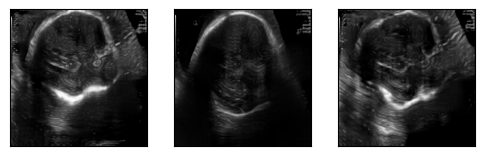

Epoch [431/500] | D loss:  1.36 | G loss:  0.82 | P(apa): 0.00
Epoch [432/500] | D loss:  1.46 | G loss:  1.02 | P(apa): 0.00
Epoch [433/500] | D loss:  1.43 | G loss:  0.62 | P(apa): 0.00
Epoch [434/500] | D loss:  1.33 | G loss:  0.79 | P(apa): 0.00
Epoch [435/500] | D loss:  1.35 | G loss:  0.78 | P(apa): 0.00
Epoch [436/500] | D loss:  1.36 | G loss:  0.77 | P(apa): 0.00
Epoch [437/500] | D loss:  1.39 | G loss:  0.76 | P(apa): 0.00
Epoch [438/500] | D loss:  1.33 | G loss:  0.83 | P(apa): 0.00
Epoch [439/500] | D loss:  1.35 | G loss:  0.91 | P(apa): 0.00
Epoch [440/500] | D loss:  1.39 | G loss:  0.66 | P(apa): 0.00
Check point saved; FID: 28.99


<Figure size 640x480 with 0 Axes>

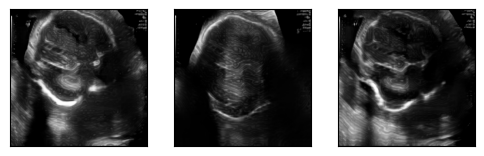

Epoch [441/500] | D loss:  1.33 | G loss:  0.76 | P(apa): 0.00
Epoch [442/500] | D loss:  1.34 | G loss:  0.69 | P(apa): 0.00
Epoch [443/500] | D loss:  1.40 | G loss:  0.79 | P(apa): 0.00
Epoch [444/500] | D loss:  1.31 | G loss:  0.69 | P(apa): 0.00
Epoch [445/500] | D loss:  1.36 | G loss:  0.77 | P(apa): 0.00
Epoch [446/500] | D loss:  1.40 | G loss:  0.66 | P(apa): 0.00
Epoch [447/500] | D loss:  1.36 | G loss:  0.72 | P(apa): 0.00
Epoch [448/500] | D loss:  1.39 | G loss:  0.65 | P(apa): 0.00
Epoch [449/500] | D loss:  1.35 | G loss:  0.77 | P(apa): 0.00
Epoch [450/500] | D loss:  1.29 | G loss:  0.59 | P(apa): 0.00
Check point saved; FID: 28.48


<Figure size 640x480 with 0 Axes>

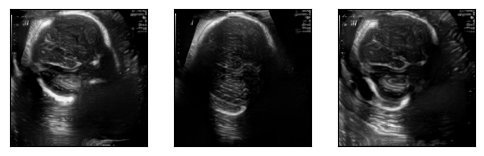

Epoch [451/500] | D loss:  1.33 | G loss:  0.83 | P(apa): 0.00
Epoch [452/500] | D loss:  1.36 | G loss:  0.82 | P(apa): 0.00
Epoch [453/500] | D loss:  1.36 | G loss:  0.75 | P(apa): 0.00
Epoch [454/500] | D loss:  1.38 | G loss:  0.81 | P(apa): 0.00
Epoch [455/500] | D loss:  1.52 | G loss:  0.59 | P(apa): 0.00
Epoch [456/500] | D loss:  1.37 | G loss:  0.69 | P(apa): 0.00
Epoch [457/500] | D loss:  1.35 | G loss:  0.80 | P(apa): 0.00
Epoch [458/500] | D loss:  1.31 | G loss:  0.79 | P(apa): 0.00
Epoch [459/500] | D loss:  1.33 | G loss:  0.85 | P(apa): 0.00
Epoch [460/500] | D loss:  1.37 | G loss:  0.72 | P(apa): 0.00
Check point saved; FID: 33.40


<Figure size 640x480 with 0 Axes>

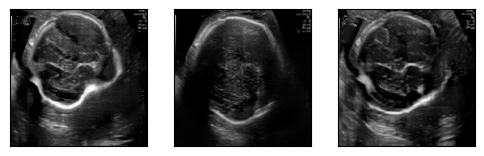

Epoch [461/500] | D loss:  1.42 | G loss:  0.76 | P(apa): 0.00
Epoch [462/500] | D loss:  1.38 | G loss:  0.78 | P(apa): 0.00
Epoch [463/500] | D loss:  1.36 | G loss:  0.65 | P(apa): 0.00
Epoch [464/500] | D loss:  1.50 | G loss:  0.79 | P(apa): 0.00
Epoch [465/500] | D loss:  1.38 | G loss:  0.75 | P(apa): 0.00
Epoch [466/500] | D loss:  1.40 | G loss:  0.72 | P(apa): 0.00
Epoch [467/500] | D loss:  1.40 | G loss:  0.61 | P(apa): 0.00
Epoch [468/500] | D loss:  1.33 | G loss:  0.83 | P(apa): 0.00
Epoch [469/500] | D loss:  1.37 | G loss:  0.78 | P(apa): 0.00
Epoch [470/500] | D loss:  1.35 | G loss:  0.69 | P(apa): 0.00
Check point saved; FID: 26.00


<Figure size 640x480 with 0 Axes>

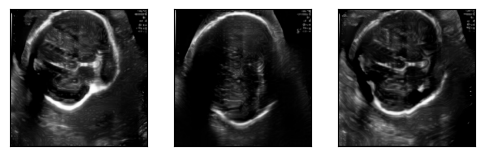

Epoch [471/500] | D loss:  1.40 | G loss:  0.73 | P(apa): 0.00
Epoch [472/500] | D loss:  1.38 | G loss:  0.69 | P(apa): 0.00
Epoch [473/500] | D loss:  1.44 | G loss:  0.67 | P(apa): 0.00
Epoch [474/500] | D loss:  1.42 | G loss:  0.91 | P(apa): 0.00
Epoch [475/500] | D loss:  1.34 | G loss:  0.64 | P(apa): 0.00
Epoch [476/500] | D loss:  1.48 | G loss:  0.72 | P(apa): 0.00
Epoch [477/500] | D loss:  1.37 | G loss:  0.75 | P(apa): 0.00
Epoch [478/500] | D loss:  1.36 | G loss:  0.79 | P(apa): 0.00
Epoch [479/500] | D loss:  1.34 | G loss:  0.76 | P(apa): 0.00
Epoch [480/500] | D loss:  1.38 | G loss:  0.81 | P(apa): 0.00
Check point saved; FID: 34.10


<Figure size 640x480 with 0 Axes>

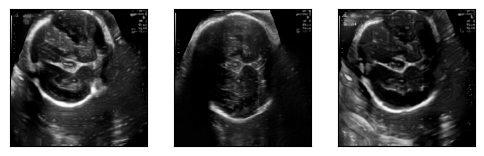

Epoch [481/500] | D loss:  1.39 | G loss:  0.62 | P(apa): 0.00
Epoch [482/500] | D loss:  1.37 | G loss:  0.75 | P(apa): 0.00
Epoch [483/500] | D loss:  1.32 | G loss:  0.68 | P(apa): 0.00
Epoch [484/500] | D loss:  1.41 | G loss:  0.64 | P(apa): 0.00
Epoch [485/500] | D loss:  1.31 | G loss:  0.71 | P(apa): 0.00
Epoch [486/500] | D loss:  1.34 | G loss:  0.70 | P(apa): 0.00
Epoch [487/500] | D loss:  1.33 | G loss:  0.80 | P(apa): 0.00
Epoch [488/500] | D loss:  1.31 | G loss:  0.79 | P(apa): 0.00
Epoch [489/500] | D loss:  1.35 | G loss:  0.68 | P(apa): 0.00
Epoch [490/500] | D loss:  1.48 | G loss:  0.78 | P(apa): 0.00
Check point saved; FID: 21.56


<Figure size 640x480 with 0 Axes>

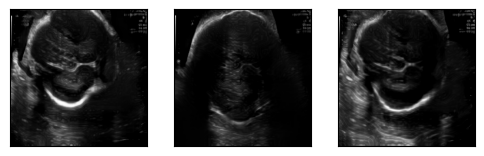

Epoch [491/500] | D loss:  1.41 | G loss:  0.80 | P(apa): 0.00
Epoch [492/500] | D loss:  1.38 | G loss:  0.80 | P(apa): 0.00
Epoch [493/500] | D loss:  1.33 | G loss:  0.85 | P(apa): 0.00
Epoch [494/500] | D loss:  1.34 | G loss:  0.80 | P(apa): 0.00
Epoch [495/500] | D loss:  1.36 | G loss:  0.83 | P(apa): 0.00
Epoch [496/500] | D loss:  1.34 | G loss:  0.73 | P(apa): 0.00
Epoch [497/500] | D loss:  1.38 | G loss:  0.73 | P(apa): 0.00
Epoch [498/500] | D loss:  1.37 | G loss:  0.69 | P(apa): 0.00
Epoch [499/500] | D loss:  1.37 | G loss:  0.76 | P(apa): 0.00
Epoch [500/500] | D loss:  1.37 | G loss:  0.65 | P(apa): 0.00
Check point saved; FID: 26.29


<Figure size 640x480 with 0 Axes>

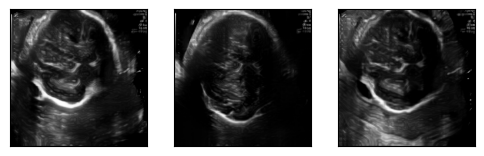

<Figure size 640x480 with 0 Axes>

In [11]:
fixed_latent_vector = torch.randn(3, latent_dim).float().to(device)
fixed_FID_vector = torch.randn(test_len, latent_dim).float().to(device)

losses = []
fids = []

discriminator.train()
generator.train()

for epoch in range(n_epochs):
    for i, real_images in enumerate(train_dataloader):
        real_images = real_images.to(device)

        d_loss, APA_p = discriminator_step(batch_size, latent_dim, real_images, APA_p)
        g_loss = generator_step(batch_size, latent_dim)

    d = d_loss['loss'].item()
    g = g_loss['loss'].item()
    losses.append((d, g))
    

    # print discriminator and generator loss
    print(f'Epoch [{epoch+1:3}/{n_epochs}] | D loss: {d:5.2f} | G loss: {g:5.2f} | P(apa): {APA_p:.2f}')
    
    if (epoch+1) % 10 == 0:
        generator.eval()
        with torch.no_grad():
            fid_img_list = []
            for i in range(test_len):
                fid_img = denormalize(generator(fixed_FID_vector[i].unsqueeze(0))).detach().cpu()
                fid_img_list.append(fid_img)

            fid_cat = torch.cat(fid_img_list)
            fid.update(test_data, real=True)
            fid.update(expand_channel(fid_cat), real=False)
            current_fid = fid.compute().item()
            fids.append(current_fid)
            fid.reset()
            
            # save checpoint
            torch.save(discriminator.state_dict(), checkpoint_path+f'd_{epoch+1:03}.pt')
            torch.save(generator.state_dict(), checkpoint_path+f'g_{epoch+1:03}.pt')
            print(f'Check point saved; FID: {current_fid:.2f}')

            # display images during training
            generated_images = generator(fixed_latent_vector)
            display(generated_images)
            del generated_images



## 6. Plot losses and FIDs



### 6.1 Training losses


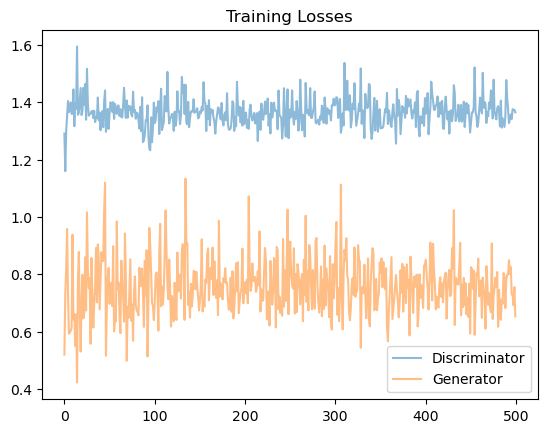

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()



### 6.2 FIDs


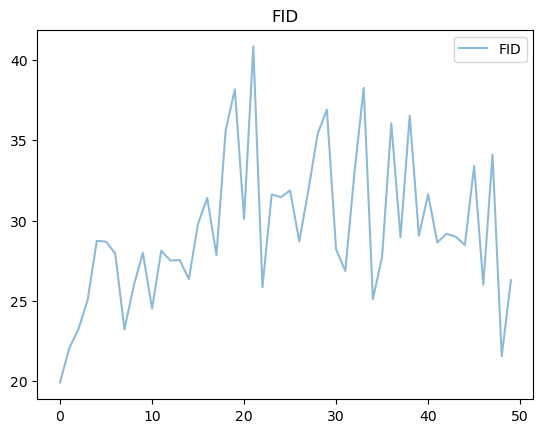

In [13]:
fig, ax = plt.subplots()
plt.plot(fids, label='FID', alpha=0.5)
plt.title("FID")
plt.legend()



### 6.3 Export logs


In [14]:
import numpy as np


D_loss_log = losses.T[0]
G_loss_log = losses.T[1]
fid_log = np.array(fids)
np.save('logs/tt_500_D_loss_log.npy', D_loss_log)
np.save('logs/tt_500_G_loss_log.npy', G_loss_log)
np.save('logs/tt_500_FID_log.npy', fid_log)
